In [52]:
from datasets import load_dataset
import pandas as pd
import numpy as  np
import re

# Load the dataset and select the first 100,000 rows, then take a subset of 1,000
ds = load_dataset("MohammadOthman/mo-customer-support-tweets-945k")
data = ds['train'].select(range(200000)).to_pandas()
# data_subset = data.head(1000)  # Subset for demonstration
data_subset = data

####################################
# Drop rows with NaN values in 'input' or 'output'
data_subset.dropna(subset=['input', 'output'], inplace=True)

# Drop rows with empty strings or only one word in either 'input' or 'output'
def is_valid(text):
    return isinstance(text, str) and len(text.strip().split()) > 1

data_subset = data_subset[data_subset['input'].apply(is_valid)]
data_subset = data_subset[data_subset['output'].apply(is_valid)]

# Reset index after filtering
data_subset.reset_index(drop=True, inplace=True)

print("Cleaned subset shape:", data_subset.shape)
############################################################


# Preprocess text: lowercase and remove special characters
def preprocess_text(text):
    if not isinstance(text, str):  # Handle non-string inputs
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.strip()

# Apply preprocessing to input and output columns
data_subset['input'] = data_subset['input'].apply(preprocess_text)
data_subset['output'] = data_subset['output'].apply(preprocess_text)

print("Subset shape:", data_subset.shape)

Cleaned subset shape: (193274, 2)
Subset shape: (193274, 2)


In [53]:
# data_subset[['output', 'input']].to_csv('main_data.csv', index = False)

In [54]:
data_subset.head()

,output,input
0,i would love the chance to review the account ...,is the worst customer service
1,h there we would definitely like to work with ...,yall lie about your great connection 5 bars lt...
2,we understand your concerns and we would like ...,since i signed up with yousince day 1
3,this is saddening to hear please shoot us a dm...,you gonna magically change your connectivity f...
4,please send me a private message so that i can...,whenever i contact customer support they tell ...


In [55]:

# output-- do precessing try to search some metho dto see if the language is other than english, and then i have seen somewhere wghere the words were spell wrong(try some simple method to correct the word)
# embeddings--don't do bert, try faster static embeddings from hugging face(or any faster embedding), or try tfidf later on.
# clustering on embedding-- kmeans(kmeans will be bad because of higher dimension.., for another option, try reducing dimension by pca, pls, and then on those reduced dimension , do kmeans) try other clustering methods like tsne, umap, try other fast clustering which is good for higher dimension

# in future--, for each cluster, we will try to implement something like different kind chatbiot we can develop


In [56]:
data_subset['conversation'] = data_subset['input'] + " " + data_subset['output']

In [57]:
import pandas as pd
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from pandarallel import pandarallel

# Ensures consistent language detection
DetectorFactory.seed = 0

# Initialize pandarallel
pandarallel.initialize(progress_bar=True)  # Set to False to hide progress bar

# Sample large DataFrame (replace this with your actual one)
# df = pd.read_csv("your_large_file.csv")
# Let's say the relevant column is 'text'
# For demo:
# df = pd.DataFrame({'text': [...large text list...]})

# Function to check if text is English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

# Use parallel apply
# df['is_english'] = df['text'].parallel_apply(is_english)

# # Filter for English rows only
# df_english = df[df['is_english']].drop(columns='is_english').reset_index(drop=True)

# # Done!
# print(df_english.head())


INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [58]:
data_subset['is_english'] = data_subset['conversation'].parallel_apply(is_english)

# Filter for English rows only
data_subset = data_subset[data_subset['is_english']].drop(columns='is_english').reset_index(drop=True)

# Done!


In [59]:
data_subset.shape

(185457, 3)

In [20]:
# from transformers import BertTokenizer, BertModel
# import torch
# import numpy as np

# # Load BERT tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')

# # Function to generate BERT embeddings
# def get_bert_embedding(text):
#     if not text:  # Handle empty strings
#         return np.zeros(768)  # Return zero vector for empty text
#     inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     # Use the [CLS] token embedding
#     return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# # Generate embeddings for agent responses
# embeddings_list = [get_bert_embedding(text) for text in data_subset['conversation']]
# embeddings_matrix = np.array(embeddings_list)

# print("Embeddings matrix shape:", embeddings_matrix.shape)

In [21]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch, numpy as np
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import BertTokenizer, BertModel

# 1) Setup
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# model     = DistilBertModel.from_pretrained('distilbert-base-uncased')
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# 2) Dataset returns raw text
class ConversationDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        # Return the raw string (empty→"")
        return self.texts[idx] or ""

# 3) collate_fn: batch→tokenized, padded tensors
def collate_fn(batch_texts):
    # batch_texts: list[str]
    encoded = tokenizer(
        batch_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    )
    # move to device
    return {k: v.to(device) for k, v in encoded.items()}

# 4) Embedding function
@torch.no_grad()
def get_bert_embeddings_batch(batch):
    outputs = model(**batch)
    # take [CLS] token (first token) out, move to CPU numpy
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

# 5) DataLoader with custom collate_fn
batch_size = 64
dataset    = ConversationDataset(data_subset['conversation'].tolist())
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,  # ← ensures uniform padding
    num_workers=0           # safe for notebooks
)

# 6) Generate embeddings
emb_list = []
for batch in tqdm(dataloader, desc="Embedding batches"):
    emb = get_bert_embeddings_batch(batch)
    emb_list.append(emb)

embeddings_matrix = np.vstack(emb_list)
print("Embeddings matrix shape:", embeddings_matrix.shape)


Embedding batches:   0%|          | 0/3020 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [8]:
# import torch
# import numpy as np
# from transformers import BertTokenizer, BertModel
# import torch_xla
# import torch_xla.core.xla_model as xm
# from tqdm import tqdm

# # Set the device to TPU
# device = xm.xla_device()

# # Load tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')
# model.to(device)
# model.eval()

# # Function to get CLS embedding from BERT using TPU
# def get_bert_embedding(text):
#     if not text or not isinstance(text, str):
#         return np.zeros(768)
    
#     # Tokenize and move to TPU device
#     inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
#     inputs = {key: val.to(device) for key, val in inputs.items()}

#     with torch.no_grad():
#         outputs = model(**inputs)

#     # Move to CPU before converting to numpy
#     cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
#     return cls_embedding

# # Apply function to each row in your dataset (assuming 'conversation' column exists)
# embeddings_list = [get_bert_embedding(text) for text in tqdm(data_subset['conversation'])]
# embeddings_matrix = np.array(embeddings_list)

# print("Embeddings matrix shape:", embeddings_matrix.shape)


In [9]:
# from transformers import BertTokenizer, BertModel
# import torch
# import numpy as np

# # Load BERT tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')

# # Move model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# model.eval()

# # Function to generate BERT embeddings using GPU
# def get_bert_embedding(text):
#     if not text:
#         return np.zeros(768)  # Handle empty or null strings

#     # Tokenize and move tensors to device
#     inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

#     with torch.no_grad():
#         outputs = model(**inputs)

#     # Get the [CLS] token embedding, move back to CPU before converting to NumPy
#     cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
#     return cls_embedding

# # Generate embeddings for agent responses
# from tqdm import tqdm

# embeddings_list = [get_bert_embedding(text) for text in tqdm(data_subset['conversation'])]

# # embeddings_list = [get_bert_embedding(text) for text in data_subset['conversation']]
# embeddings_matrix = np.array(embeddings_list)

# print("Embeddings matrix shape:", embeddings_matrix.shape)

# this got stopped after 16 percent, 75k rows/466k rows


In [29]:
# saving and loading embeddings
import numpy as np
# Save the embeddings matrix to a file
np.save("bert_embeddings_kaggle.npy", embeddings_matrix)
print("Embeddings saved to 'bert_embeddings.npy'")


Embeddings saved to 'bert_embeddings.npy'


In [38]:
# loading embeddings
# Load the saved embeddings
import numpy as np
embeddings_matrix = np.load("bert_embeddings_kaggle_200k.npy")
print("Loaded embeddings shape:", embeddings_matrix.shape)


Loaded embeddings shape: (185457, 768)


In [39]:
import umap.umap_ as umap

# Reduce to 50 dimensions with UMAP
umap_reducer = umap.UMAP(n_components=50, random_state=42, n_neighbors=15, min_dist=0.1)
reduced_embeddings_umap = umap_reducer.fit_transform(embeddings_matrix)

print("UMAP reduced shape:", reduced_embeddings_umap.shape)

/Users/ritikojha/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP reduced shape: (185457, 50)


In [40]:
umap_reduced_data = pd.DataFrame(reduced_embeddings_umap)
umap_reduced_data.to_csv('reduced_embeddings_umap_200k.csv')

In [41]:
# from sklearn.decomposition import TruncatedSVD

# # Reduce to 50 dimensions with SVD
# svd = TruncatedSVD(n_components=50, random_state=42)
# reduced_embeddings_svd = svd.fit_transform(embeddings_matrix)

# print("SVD reduced shape:", reduced_embeddings_svd.shape)

In [42]:
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=30)
# reduced_embeddings_tsne = tsne.fit_transform(embeddings_matrix)


In [43]:
# from sklearn.cluster import MiniBatchKMeans

# # On UMAP-reduced data
# minibatch_kmeans_umap = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=100)
# clusters_minibatch_umap = minibatch_kmeans_umap.fit_predict(reduced_embeddings_umap)

# On SVD-reduced data
# minibatch_kmeans_svd = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=100)
# clusters_minibatch_svd = minibatch_kmeans_svd.fit_predict(reduced_embeddings_svd)

# minibatch_kmeans_tsne = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=100)
# clusters_minibatch_tsne = minibatch_kmeans_tsne.fit_predict(reduced_embeddings_tsne)


Optimal number of clusters by silhouette score: 4


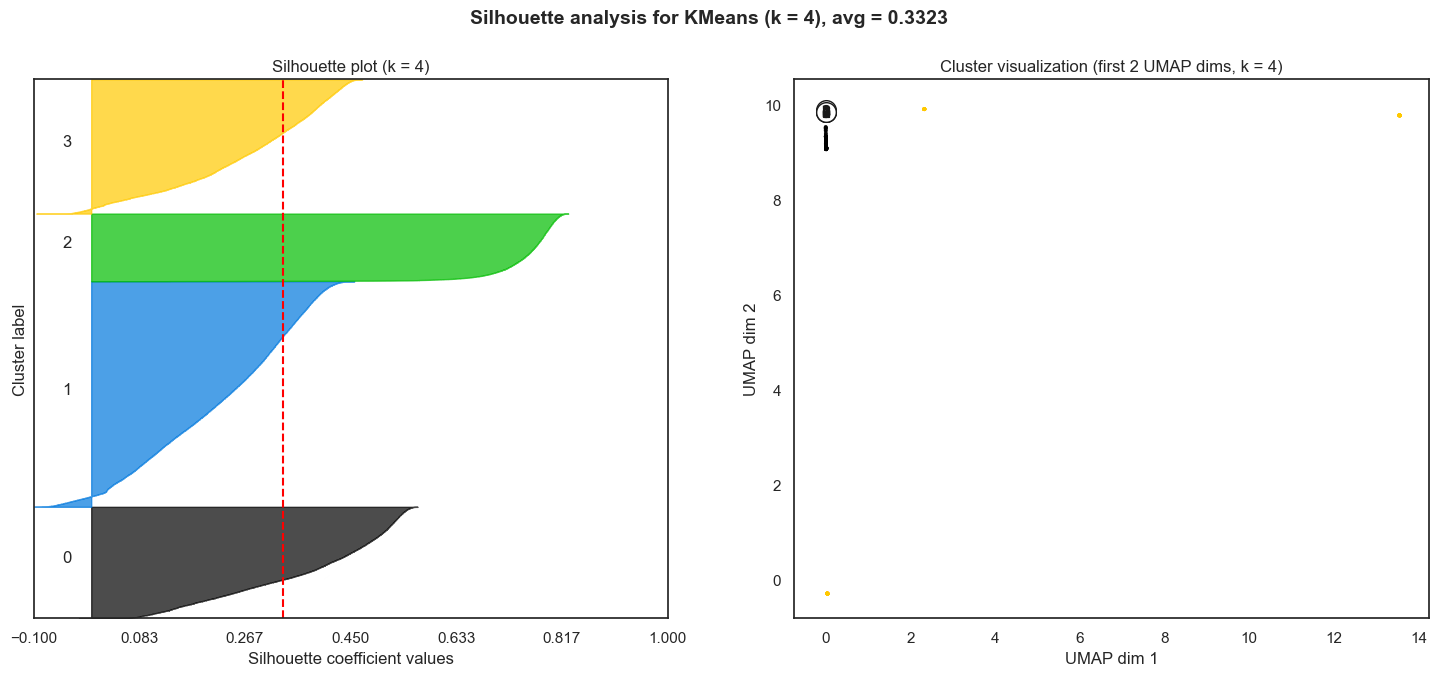

In [88]:
# SPDX-License-Identifier: BSD-3-Clause

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

import umap.umap_ as umap

# -----------------------------------------------------------------------------
# 1. UMAP reduction of your BERT embeddings
# -----------------------------------------------------------------------------
# Assume `embeddings_matrix` is your (n_samples × 768) BERT embedding array
# umap_reducer = umap.UMAP(
#     n_components=50,
#     random_state=42,
#     n_neighbors=15,
#     min_dist=0.1
# )
# reduced_embeddings_umap = umap_reducer.fit_transform(embeddings_matrix)
# print("UMAP reduced shape:", reduced_embeddings_umap.shape)

# Use the reduced data for clustering
X = reduced_embeddings_umap

# -----------------------------------------------------------------------------
# 2. Compute average silhouette scores for different k
# -----------------------------------------------------------------------------
# range_n_clusters = [2, 3, 4, 5, 6]
# silhouette_avgs = []

# for n_clusters in range_n_clusters:
#     # Perform KMeans
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     labels = kmeans.fit_predict(X)

#     # Compute average silhouette score
#     sil_avg = silhouette_score(X, labels)
#     silhouette_avgs.append(sil_avg)
#     print(f"For n_clusters = {n_clusters}, average silhouette_score = {sil_avg:.4f}")

# -----------------------------------------------------------------------------
# 3. Select and report the optimal number of clusters
# -----------------------------------------------------------------------------
# best_idx = np.argmax(silhouette_avgs)
# best_k = range_n_clusters[best_idx]
best_k = 4
print(f"\nOptimal number of clusters by silhouette score: {best_k}")

# -----------------------------------------------------------------------------
# 4. Plot silhouette score vs. number of clusters
# -----------------------------------------------------------------------------
# plt.figure(figsize=(8, 4))
# plt.plot(range_n_clusters, silhouette_avgs, marker='o', linewidth=2)
# plt.xticks(range_n_clusters)
# plt.xlabel("Number of clusters (k)")
# plt.ylabel("Average silhouette score")
# plt.title("Silhouette score vs. number of clusters")
# plt.axvline(best_k, color='red', linestyle='--', label=f"Best k = {best_k}")
# plt.legend()
# plt.tight_layout()
# plt.show()

# -----------------------------------------------------------------------------
# 5. (Optional) Detailed silhouette plot for best_k
# -----------------------------------------------------------------------------
n_clusters = best_k
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Silhouette plot parameters
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# Fit KMeans for best_k
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Compute silhouette metrics
sil_avg = silhouette_score(X, cluster_labels)
sample_sil_vals = silhouette_samples(X, cluster_labels)

# Plot individual silhouette plots
y_lower = 10
for i in range(n_clusters):
    ith_vals = sample_sil_vals[cluster_labels == i]
    ith_vals.sort()
    size_i = ith_vals.shape[0]
    y_upper = y_lower + size_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_vals,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )
    ax1.text(-0.05, y_lower + 0.5 * size_i, str(i))
    y_lower = y_upper + 10

ax1.axvline(x=sil_avg, color="red", linestyle="--")
ax1.set_title(f"Silhouette plot (k = {n_clusters})")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")
ax1.set_yticks([])
ax1.set_xticks(np.linspace(-0.1, 1.0, 7))

# Cluster scatter plot in first two UMAP dimensions
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    X[:, 0], X[:, 1],
    marker='.', s=30, lw=0, alpha=0.7,
    c=colors, edgecolor='k'
)
centers = kmeans.cluster_centers_[:, :2]
ax2.scatter(
    centers[:, 0], centers[:, 1],
    marker='o', c='white', alpha=1,
    s=200, edgecolor='k'
)
for idx, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker=f'${idx}$', alpha=1, s=50, edgecolor='k')

ax2.set_title(f"Cluster visualization (first 2 UMAP dims, k = {n_clusters})")
ax2.set_xlabel("UMAP dim 1")
ax2.set_ylabel("UMAP dim 2")

plt.suptitle(
    f"Silhouette analysis for KMeans (k = {n_clusters}), avg = {sil_avg:.4f}",
    fontsize=14, fontweight='bold'
)
plt.show()


In [44]:
from sklearn.cluster import KMeans

# On UMAP-reduced data
kmeans_umap = KMeans(n_clusters=4, random_state=42)
clusters_kmeans_umap = kmeans_umap.fit_predict(reduced_embeddings_umap)

# On SVD-reduced data
# kmeans_svd = KMeans(n_clusters=4, random_state=42)
# clusters_kmeans_svd = kmeans_svd.fit_predict(reduced_embeddings_svd)

# On tsne-reduced data
# kmeans_tsne = KMeans(n_clusters=4, random_state=42)
# clusters_kmeans_tsne = kmeans_tsne.fit_predict(reduced_embeddings_tsne)



In [45]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Assuming these exist:
# # reduced_embeddings_umap: 2D numpy array from UMAP
# # clusters_kmeans_umap: predicted cluster labels from KMeans

# # Number of clusters
# num_clusters = len(np.unique(clusters_kmeans_umap))

# # Set Seaborn style
# sns.set(style="white", context="notebook")

# # Create the plot
# plt.figure(figsize=(10, 7))
# scatter = plt.scatter(
#     reduced_embeddings_umap[:, 0],
#     reduced_embeddings_umap[:, 1],
#     c=clusters_kmeans_umap,
#     cmap=plt.cm.get_cmap('tab20', num_clusters),
#     s=60,
#     alpha=0.8,
#     linewidths=0.3,
#     edgecolors='gray'
# )

# # Legend with cluster IDs
# legend1 = plt.legend(*scatter.legend_elements(num=num_clusters), title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
# plt.gca().add_artist(legend1)

# # Clean axis and layout
# sns.despine()
# plt.xlabel("UMAP Dimension 1", fontsize=12)
# plt.ylabel("UMAP Dimension 2", fontsize=12)
# plt.title("Enhanced KMeans Clustering on UMAP-Reduced Embeddings", fontsize=14)
# plt.grid(False)
# plt.tight_layout()
# plt.show()


In [46]:
# # cluster ceenter
# # Optional: If you have the fitted KMeans object
# centers = kmeans_umap.cluster_centers_  # from the fitted KMeans on UMAP embeddings
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.7, marker='X', label='Centers')
# plt.legend()



In [47]:
# from sklearn.cluster import DBSCAN

# # On UMAP-reduced data
# dbscan_umap = DBSCAN(eps=0.5, min_samples=5)
# clusters_dbscan_umap = dbscan_umap.fit_predict(reduced_embeddings_umap)

# # On SVD-reduced data
# dbscan_svd = DBSCAN(eps=0.5, min_samples=5)
# clusters_dbscan_svd = dbscan_svd.fit_predict(reduced_embeddings_svd)

# dbscan_tsne = DBSCAN(eps=0.5, min_samples=5)
# clusters_dbscan_tsne = dbscan_tsne.fit_predict(reduced_embeddings_tsne)

In [62]:
# from sklearn.metrics import silhouette_score
# from joblib import Parallel, delayed
# import numpy as np

# def compute_silhouette(method, data, labels):
#     unique_labels = len(set(labels)) - (1 if -1 in labels else 0)
#     if unique_labels > 1:
#         score = silhouette_score(data, labels)
#         return (method, score, unique_labels)
#     return (method, None, unique_labels)

# methods = {
#     # 'Mini-Batch K-Means (UMAP)': (reduced_embeddings_umap, clusters_minibatch_umap),
#     'K-Means (UMAP)': (reduced_embeddings_umap, clusters_kmeans_umap),
#     # add others here
# }

# results = Parallel(n_jobs=-1)(delayed(compute_silhouette)(method, data, labels)
#                               for method, (data, labels) in methods.items())

# for method, score, k in results:
#     if score is not None:
#         print(f"{method}: Silhouette Score = {score:.4f}, Clusters = {k}")
#     else:
#         print(f"{method}: Cannot compute silhouette score (Clusters = {k})")



K-Means (UMAP): Silhouette Score = 0.3323, Clusters = 4


In [68]:
from joblib import Parallel, delayed
from sklearn.metrics import silhouette_score, silhouette_samples
import pandas as pd
import numpy as np
# import ace_tools as tools

# Define your clustering methods and corresponding data
methods = {
    'K-Means (UMAP)': (reduced_embeddings_umap, clusters_kmeans_umap),
    # add additional methods here, e.g.:
    # 'Mini-Batch K-Means (UMAP)': (reduced_embeddings_umap, clusters_minibatch_umap),
}

def compute_metrics(method_name, data, labels):
    """Compute average and per-sample silhouette scores and assemble DataFrame."""
    unique_labels = len(set(labels)) - (1 if -1 in labels else 0)
    if unique_labels > 1:
        avg_score = silhouette_score(data, labels)
        sample_scores = silhouette_samples(data, labels)
    else:
        avg_score = np.nan
        sample_scores = np.full(len(data), np.nan)
    
    # Build DataFrame for this method
    umap_cols = [f"UMAP_{i+1}" for i in range(data.shape[1])]
    df = pd.DataFrame(data, columns=umap_cols)
    df['cluster'] = labels
    df['silhouette_score'] = sample_scores
    df['method'] = method_name
    
    return method_name, avg_score, df

# Run computations in parallel
results = Parallel(n_jobs=-1)(
    delayed(compute_metrics)(name, data, labels)
    for name, (data, labels) in methods.items()
)

# Print summary of average scores
for name, avg_score, df in results:
    n_clusters = df['cluster'].nunique()
    print(f"{name}: average silhouette score = {avg_score:.4f}, clusters = {n_clusters}")

# Combine all results into a single DataFrame
df_all = pd.concat([df for _, _, df in results], ignore_index=True)

# Display interactively
# tools.display_dataframe_to_user(
#     name="Clustering Results: UMAP Embeddings, Clusters & Silhouette Scores",
#     dataframe=df_all
# )


K-Means (UMAP): average silhouette score = 0.3323, clusters = 4


In [69]:
df_all.head()

,UMAP_1,UMAP_2,UMAP_3,UMAP_4,UMAP_5,UMAP_6,UMAP_7,UMAP_8,UMAP_9,UMAP_10,...,UMAP_44,UMAP_45,UMAP_46,UMAP_47,UMAP_48,UMAP_49,UMAP_50,cluster,silhouette_score,method
0,0.002446,9.841280,9.999330,7.246926,9.036859,0.074599,2.567662,9.745844,9.987209,0.859213,...,5.747022,1.684068,5.140978,5.436244,7.280256,4.896312,1.676397,1,0.177668,K-Means (UMAP)
1,-0.003099,9.877289,10.004237,7.361410,8.905058,0.074745,2.506513,9.799313,9.971335,0.712274,...,5.480466,1.658872,5.338668,5.333527,7.254408,4.689448,1.803949,2,0.787499,K-Means (UMAP)
2,0.007934,9.841823,9.993334,7.259352,9.350680,0.070695,2.546952,9.692939,9.991090,0.819629,...,5.313294,1.647133,5.670973,5.293328,7.212524,4.348283,1.885973,1,0.367549,K-Means (UMAP)
3,0.008542,9.844964,9.994274,7.275265,9.365328,0.072857,2.528430,9.728966,9.989092,0.809499,...,5.282391,1.645526,5.725426,5.265812,7.173648,4.420669,1.770745,1,0.335302,K-Means (UMAP)
4,-0.005721,9.843170,10.003098,7.255713,8.777501,0.066460,2.562150,9.728903,9.996612,0.843249,...,6.021799,1.566827,4.931820,5.229795,7.171795,4.733301,2.163776,1,-0.033960,K-Means (UMAP)


In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_silhouette(df_all: pd.DataFrame, method_name: str):
    """
    Plot a silhouette‐width bar chart for a given clustering method,
    based on the combined df_all which must contain columns:
      - 'silhouette_score'
      - 'cluster'
      - 'method'
    """
    # 1) Filter to the desired method
    df = df_all[df_all['method'] == method_name].copy()
    if df.empty:
        raise ValueError(f"No rows found for method '{method_name}'")
    
    # 2) Sort by cluster then descending silhouette score
    df_sorted = df.sort_values(
        by=['cluster', 'silhouette_score'],
        ascending=[True, False]
    ).reset_index(drop=True)
    
    # 3) Create an integer index for plotting on the x-axis
    df_sorted['sample_idx'] = np.arange(len(df_sorted))
    
    # 4) Draw the barplot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x='sample_idx',
        y='silhouette_score',
        hue='cluster',
        data=df_sorted,
        dodge=False,
        palette='Set1',
        edgecolor='k',
        linewidth=0.2
    )
    
    # 5) Formatting
    plt.axhline(0, color='k', linestyle='--', linewidth=1)
    plt.title(f"Silhouette Plot for {method_name}", fontsize=14)
    plt.xlabel("Samples (ordered by cluster)", fontsize=12)
    plt.ylabel("Silhouette Score", fontsize=12)
    plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xticks([], [])   # hide x‑ticks (too many samples)
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_silhouette(df_all, 'K-Means (UMAP)')


In [70]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import silhouette_samples
# import pandas as pd

# def plot_silhouette(data, labels, method_name):
#     # Compute silhouette scores per sample
#     sil_samples = silhouette_samples(data, labels)

#     # Create a DataFrame for plotting
#     df_sil = pd.DataFrame({
#         'silhouette_score': sil_samples,
#         'cluster': labels
#     })

#     # Remove noise cluster (-1) if DBSCAN was used
#     # df_sil = df_sil[df_sil['cluster'] != -1]

#     # Sort for better visual grouping
#     df_sil_sorted = df_sil.sort_values(by=['cluster', 'silhouette_score'], ascending=[True, False])

#     # Plot
#     plt.figure(figsize=(10, 6))
#     sns.barplot(
#         x=np.arange(len(df_sil_sorted)),
#         y='silhouette_score',
#         hue='cluster',
#         dodge=False,
#         data=df_sil_sorted,
#         palette='Set1'
#     )
#     plt.title(f"Silhouette Plot for {method_name}")
#     plt.ylabel("Silhouette Score")
#     plt.xlabel("Samples (ordered by cluster)")
#     plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()
#     plt.show()


In [78]:
# plot_silhouette(reduced_embeddings_umap, clusters_kmeans_umap, "K-Means (UMAP)")


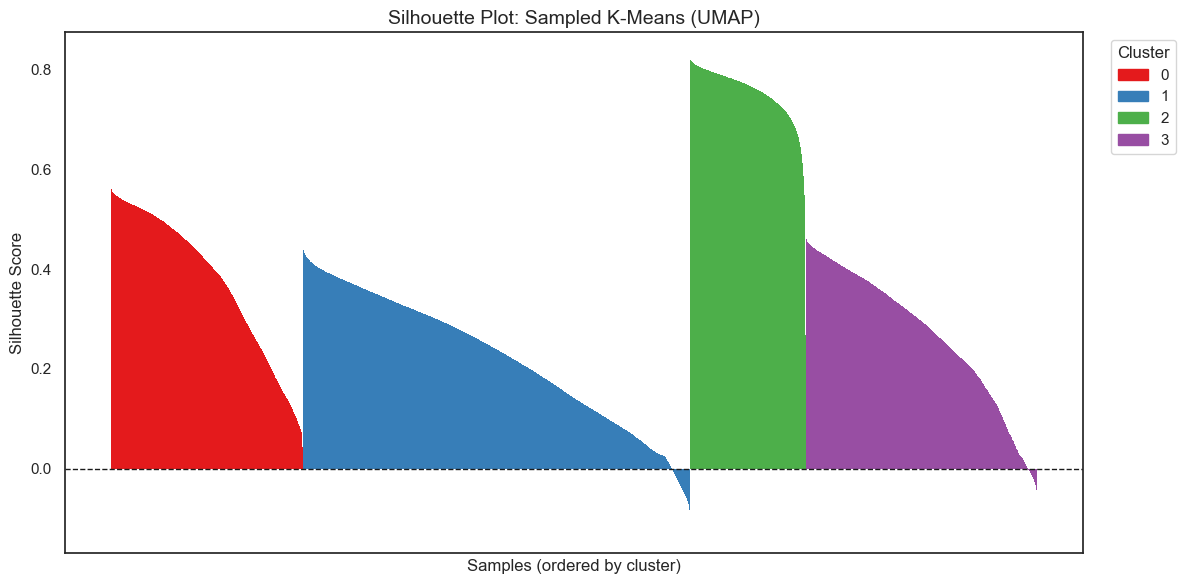

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# 1) Filter your combined df_all for the method you care about
# df_kmeans = df_all[df_all['method'] == 'K-Means (UMAP)'].copy()
df_kmeans = df_all.copy()

# 2) Subsample for speed (e.g. 50 000 rows out of however many you have)
# df_sampled = df_kmeans.sample(n=50000, random_state=42)
df_sampled = df_all
def plot_silhouette_df(df: pd.DataFrame, title: str):
    """
    df must contain:
      - 'silhouette_score'
      - 'cluster'
    """
    # 1) Sort by cluster then descending silhouette
    df_sorted = df.sort_values(
        by=['cluster', 'silhouette_score'],
        ascending=[True, False]
    ).reset_index(drop=True)
    df_sorted['sample_idx'] = np.arange(len(df_sorted))

    # 2) Build Set1 palette and map each cluster → its color
    clusters = sorted(df_sorted['cluster'].unique())
    palette = sns.color_palette('Set1', n_colors=len(clusters))
    cluster_to_color = {c: palette[i] for i, c in enumerate(clusters)}
    bar_colors = [cluster_to_color[c] for c in df_sorted['cluster']]

    # 3) Plot with plt.bar so each bar can have its own color
    plt.figure(figsize=(12, 6))
    plt.bar(
        df_sorted['sample_idx'],
        df_sorted['silhouette_score'],
        color=bar_colors,
        width=1.0,          # full coverage of each integer index
        align='center',
        edgecolor='none'
    )

    # 4) Zero line
    plt.axhline(0, color='k', linestyle='--', linewidth=1)

    # 5) Legend: one patch per cluster
    handles = [plt.Rectangle((0,0),1,1, color=cluster_to_color[c]) for c in clusters]
    plt.legend(handles, clusters,
               title='Cluster',
               bbox_to_anchor=(1.02, 1),
               loc='upper left')

    # 6) Labels & styling
    plt.title(f"Silhouette Plot: {title}", fontsize=14)
    plt.xlabel("Samples (ordered by cluster)", fontsize=12)
    plt.ylabel("Silhouette Score", fontsize=12)
    plt.xticks([], [])   # hide x‐ticks
    plt.tight_layout()
    plt.show()

# 4) Call it on the subsample
plot_silhouette_df(df_sampled, "Sampled K-Means (UMAP)")


In [50]:
import numpy as np
from scipy.spatial.distance import cdist

def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    # unique_clusters = unique_clusters[unique_clusters != -1]  # Remove noise if any

    if len(unique_clusters) < 2:
        return np.nan  # Dunn index is undefined for <2 clusters

    # Compute inter-cluster distances (min between any two clusters)
    min_intercluster = np.inf
    for i, ci in enumerate(unique_clusters):
        for j, cj in enumerate(unique_clusters):
            if i < j:
                dist = cdist(X[labels == ci], X[labels == cj])
                min_intercluster = min(min_intercluster, np.min(dist))

    # Compute intra-cluster distances (max diameter within any cluster)
    max_intracluster = 0
    for c in unique_clusters:
        points = X[labels == c]
        if len(points) > 1:
            dist = cdist(points, points)
            max_intracluster = max(max_intracluster, np.max(dist))

    # Return Dunn index
    return min_intercluster / max_intracluster if max_intracluster != 0 else np.nan


In [ ]:
dunn = dunn_index(reduced_embeddings_umap, clusters_kmeans_umap)
print(f"Dunn Index (K-Means UMAP): {dunn:.4f}")


In [73]:
data_subset.shape, df_all.shape

((185457, 4), (185457, 53))

In [74]:
data_subset['silhoutte_score'] = df_all['silhouette_score']

In [75]:
data_subset

,output,input,conversation,kmeans_umap_cluster,silhoutte_score
0,i would love the chance to review the account ...,is the worst customer service,is the worst customer service i would love the...,1,0.177668
1,h there we would definitely like to work with ...,yall lie about your great connection 5 bars lt...,yall lie about your great connection 5 bars lt...,2,0.787499
2,we understand your concerns and we would like ...,since i signed up with yousince day 1,since i signed up with yousince day 1 we under...,1,0.367549
3,this is saddening to hear please shoot us a dm...,you gonna magically change your connectivity f...,you gonna magically change your connectivity f...,1,0.335302
4,please send me a private message so that i can...,whenever i contact customer support they tell ...,whenever i contact customer support they tell ...,1,-0.033960
...,...,...,...,...,...
185452,i am sorry for the trouble john we would like ...,why did your driver leave my food behind the g...,why did your driver leave my food behind the g...,1,0.242908
185453,i am sorry for the trouble watching your video...,i am trying to watch splash for thanksgiving a...,i am trying to watch splash for thanksgiving a...,0,0.480262
185454,we are here to help which device is this occur...,hey ever since i update my ios my and apps cr...,hey ever since i update my ios my and apps cr...,0,0.516987
185455,thanks for that info and do you have any updat...,i have a 6 and the ios 1111,i have a 6 and the ios 1111 thanks for that in...,0,0.544525


In [60]:
# Add cluster labels to the subset
data_subset['kmeans_umap_cluster'] = clusters_kmeans_umap

# Print 2 examples from each cluster
for cluster in range(3):
    print(f"\nCluster {cluster} (K-Means UMAP):")
    cluster_data = data_subset[data_subset['kmeans_umap_cluster'] == cluster]['output'].head(2)
    for i, text in enumerate(cluster_data):
        print(f"Example {i+1}: {text}")


Cluster 0 (K-Means UMAP):
Example 1: are all your services cutting out
Example 2: did the lights change on the router when this happened

Cluster 1 (K-Means UMAP):
Example 1: i would love the chance to review the account and provide assistance
Example 2: we understand your concerns and we would like for you to please send us a direct message so that we can further assist you

Cluster 2 (K-Means UMAP):
Example 1: h there we would definitely like to work with you on this how long have you been eeriencing this issue
Example 2: hello my apologies for any frustrations or inconvenience id be happy to look into this for you


In [76]:
data_subset.to_csv('final_cluster_result_kaggle_200k.csv', index = False)

In [26]:
!pip install cuml-cu11 --extra-index-url=https://pypi.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 107.8 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 184.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.8/725.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 134.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 MB 71.5 MB/s eta 0:00:00:00:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 56.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 112.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 124.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 110.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [1]:
import cupy as cp
from cuml.metrics import silhouette_score as gpu_silhouette_score
import numpy as np

# Function to compute silhouette score on GPU
def compute_silhouette_gpu(data, labels):
    labels = cp.asarray(labels)
    data = cp.asarray(data)

    unique_labels = len(cp.unique(labels)) - (1 if -1 in labels else 0)
    if unique_labels > 1:
        return float(gpu_silhouette_score(data, labels))
    return None

# Your clustering results
methods = {
    'Mini-Batch K-Means (UMAP)': (reduced_embeddings_umap, clusters_minibatch_umap),
    'K-Means (UMAP)': (reduced_embeddings_umap, clusters_kmeans_umap),
}

# Compute silhouette scores using GPU
for method, (data, labels) in methods.items():
    score = compute_silhouette_gpu(data, labels)
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if score is not None:
        print(f"{method}: Silhouette Score = {score:.4f}, Clusters = {num_clusters}")
    else:
        print(f"{method}: Cannot compute silhouette score (Clusters = {num_clusters})")


ImportError: cannot import name 'silhouette_score' from 'cuml.metrics' (/usr/local/lib/python3.11/dist-packages/cuml/metrics/__init__.py)

In [25]:
# from sklearn.metrics import silhouette_score

# # Function to safely compute silhouette score
# def compute_silhouette(data, labels):
#     unique_labels = len(set(labels)) - (1 if -1 in labels else 0)  # Exclude noise for DBSCAN
#     if unique_labels > 1:  # Need at least 2 clusters for silhouette score
#         return silhouette_score(data, labels)
#     return None

# # Dictionary of methods and their data/labels
# methods = {
#     'Mini-Batch K-Means (UMAP)': (reduced_embeddings_umap, clusters_minibatch_umap),
#     # 'Mini-Batch K-Means (SVD)': (reduced_embeddings_svd, clusters_minibatch_svd),
#     # 'Mini-Batch K-Means (tsne)': (reduced_embeddings_tsne, clusters_minibatch_tsne),
#     'K-Means (UMAP)': (reduced_embeddings_umap, clusters_kmeans_umap),
#     # 'K-Means (SVD)': (reduced_embeddings_svd, clusters_kmeans_svd),
#     # 'K-Means (tsne)': (reduced_embeddings_tsne, clusters_kmeans_tsne),
#     # 'DBSCAN (UMAP)': (reduced_embeddings_umap, clusters_dbscan_umap),
#     # 'DBSCAN (SVD)': (reduced_embeddings_svd, clusters_dbscan_svd),
#     # 'DBSCAN (tsne)': (reduced_embeddings_tsne, clusters_dbscan_tsne),
#     # 'Spectral Clustering (UMAP)': (reduced_embeddings_umap, clusters_spectral_umap),
#     # 'Spectral Clustering (SVD)': (reduced_embeddings_svd, clusters_spectral_svd)
# }

# # Compute and print silhouette scores
# for method, (data, labels) in methods.items():
#     score = compute_silhouette(data, labels)
#     num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#     if score is not None:
#         print(f"{method}: Silhouette Score = {score:.4f}, Clusters = {num_clusters}")
#     else:
#         print(f"{method}: Cannot compute silhouette score (Clusters = {num_clusters})")


# #Mini-Batch K-Means (UMAP): Silhouette Score = 0.3382, Clusters = 4
# # Mini-Batch K-Means (SVD): Silhouette Score = 0.0919, Clusters = 4
# # K-Means (UMAP): Silhouette Score = 0.486  1, Clusters = 4
# # K-Means (SVD): Silhouette Score = 0.0793, Clusters = 4
# # DBSCAN (UMAP): Silhouette Score = -0.3241, Clusters = 36
# # DBSCAN (SVD): Silhouette Score = -0.0047, Clusters = 5

KeyboardInterrupt: 

In [29]:
from sklearn.metrics import silhouette_score
from concurrent.futures import ProcessPoolExecutor, as_completed

# Function to safely compute silhouette score
def compute_silhouette_safe(method_name, data, labels):
    unique_labels = len(set(labels)) - (1 if -1 in labels else 0)
    if unique_labels > 1:
        score = silhouette_score(data, labels)
        return method_name, score, unique_labels
    return method_name, None, unique_labels

# Define clustering outputs
methods = {
    'Mini-Batch K-Means (UMAP)': (reduced_embeddings_umap, clusters_minibatch_umap),
    # 'Mini-Batch K-Means (SVD)': (reduced_embeddings_svd, clusters_minibatch_svd),
    'K-Means (UMAP)': (reduced_embeddings_umap, clusters_kmeans_umap),
    # 'K-Means (SVD)': (reduced_embeddings_svd, clusters_kmeans_svd),
    # Add more methods as needed...
}

# Run computations in parallel
results = []
with ProcessPoolExecutor() as executor:
    futures = {
        executor.submit(compute_silhouette_safe, method, data, labels): method
        for method, (data, labels) in methods.items()
    }

    for future in as_completed(futures):
        method_name, score, num_clusters = future.result()
        if score is not None:
            print(f"{method_name}: Silhouette Score = {score:.4f}, Clusters = {num_clusters}")
        else:
            print(f"{method_name}: Cannot compute silhouette score (Clusters = {num_clusters})")


Process ForkProcess-7:
Process ForkProcess-6:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/concurrent/futures/process.py", line 249, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 102, in get
    with self._rlock:
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.

KeyboardInterrupt: 

end of project


In [ ]:
from sklearn.cluster import KMeans

# On UMAP-reduced data
kmeans_umap = KMeans(n_clusters=4, random_state=42)
clusters_kmeans_umap = kmeans_umap.fit_predict(reduced_embeddings_umap)

# On SVD-reduced data
kmeans_svd = KMeans(n_clusters=4, random_state=42)
clusters_kmeans_svd = kmeans_svd.fit_predict(reduced_embeddings_svd)

In [ ]:
from sklearn.cluster import DBSCAN

# On UMAP-reduced data
dbscan_umap = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan_umap = dbscan_umap.fit_predict(reduced_embeddings_umap)

# On SVD-reduced data
dbscan_svd = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan_svd = dbscan_svd.fit_predict(reduced_embeddings_svd)

In [ ]:
from sklearn.cluster import SpectralClustering

# On UMAP-reduced data
spectral_umap = SpectralClustering(n_clusters=3, random_state=42, affinity='nearest_neighbors')
clusters_spectral_umap = spectral_umap.fit_predict(reduced_embeddings_umap)

# On SVD-reduced data
spectral_svd = SpectralClustering(n_clusters=3, random_state=42, affinity='nearest_neighbors')
clusters_spectral_svd = spectral_svd.fit_predict(reduced_embeddings_svd)

In [ ]:
from sklearn.metrics import silhouette_score

# Function to compute silhouette score safely
def compute_silhouette(data, labels):
    unique_labels = len(set(labels))
    if unique_labels > 1 and unique_labels < len(data):  # Valid clustering
        return silhouette_score(data, labels)
    return None

# Dictionary of methods and their data/labels
methods = {
    'Mini-Batch K-Means (UMAP)': (reduced_embeddings_umap, clusters_minibatch_umap),
    'Mini-Batch K-Means (SVD)': (reduced_embeddings_svd, clusters_minibatch_svd),
    'K-Means (UMAP)': (reduced_embeddings_umap, clusters_kmeans_umap),
    'K-Means (SVD)': (reduced_embeddings_svd, clusters_kmeans_svd),
    'DBSCAN (UMAP)': (reduced_embeddings_umap, clusters_dbscan_umap),
    'DBSCAN (SVD)': (reduced_embeddings_svd, clusters_dbscan_svd),
    # 'Spectral Clustering (UMAP)': (reduced_embeddings_umap, clusters_spectral_umap),
    # 'Spectral Clustering (SVD)': (reduced_embeddings_svd, clusters_spectral_svd)
}

# Compute and print silhouette scores
for method, (data, labels) in methods.items():
    score = compute_silhouette(data, labels)
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Exclude noise for DBSCAN
    if score is not None:
        print(f"{method}: Silhouette Score = {score:.4f}, Clusters = {num_clusters}")
    else:
        print(f"{method}: Cannot compute silhouette score (Clusters = {num_clusters})")

# Mini-Batch K-Means (UMAP): Silhouette Score = 0.3382, Clusters = 4
# Mini-Batch K-Means (SVD): Silhouette Score = 0.0919, Clusters = 4
# K-Means (UMAP): Silhouette Score = 0.4861, Clusters = 4
# K-Means (SVD): Silhouette Score = 0.0793, Clusters = 4
# DBSCAN (UMAP): Silhouette Score = -0.3241, Clusters = 36
# DBSCAN (SVD): Silhouette Score = -0.0047, Clusters = 5

In [ ]:
# Add cluster labels to the subset
data_subset['kmeans_umap_cluster'] = clusters_kmeans_umap

# Print 2 examples from each cluster
for cluster in range(3):
    print(f"\nCluster {cluster} (K-Means UMAP):")
    cluster_data = data_subset[data_subset['kmeans_umap_cluster'] == cluster]['output'].head(2)
    for i, text in enumerate(cluster_data):
        print(f"Example {i+1}: {text}")

In [ ]:
data_subset.to_csv('final_cluster_result_kaggle_500k.csv', index = False)

In [91]:

data_subset.kmeans_umap_cluster.value_counts()

kmeans_umap_cluster
1    77612
3    46224
0    38339
2    23282
Name: count, dtype: int64

In [92]:
data_subset.head()

,output,input,conversation,kmeans_umap_cluster,silhoutte_score
0,i would love the chance to review the account ...,is the worst customer service,is the worst customer service i would love the...,1,0.177668
1,h there we would definitely like to work with ...,yall lie about your great connection 5 bars lt...,yall lie about your great connection 5 bars lt...,2,0.787499
2,we understand your concerns and we would like ...,since i signed up with yousince day 1,since i signed up with yousince day 1 we under...,1,0.367549
3,this is saddening to hear please shoot us a dm...,you gonna magically change your connectivity f...,you gonna magically change your connectivity f...,1,0.335302
4,please send me a private message so that i can...,whenever i contact customer support they tell ...,whenever i contact customer support they tell ...,1,-0.033960


Computing sentiment scores...
Sentiment scores added. DataFrame shape: (185457, 13)

Mean Sentiment Scores by Cluster:
 kmeans_umap_cluster  input_pos  input_neg  input_neu  input_compound  output_pos  output_neg  output_neu  output_compound
                   0   0.082085   0.074787   0.842944        0.010190    0.143982    0.028841    0.827151         0.315731
                   1   0.097218   0.092207   0.810317       -0.014617    0.164472    0.041544    0.793984         0.325862
                   2   0.082478   0.086278   0.831198       -0.018582    0.162628    0.042159    0.795208         0.326056
                   3   0.146276   0.067269   0.785720        0.130440    0.222781    0.039502    0.737673         0.374681


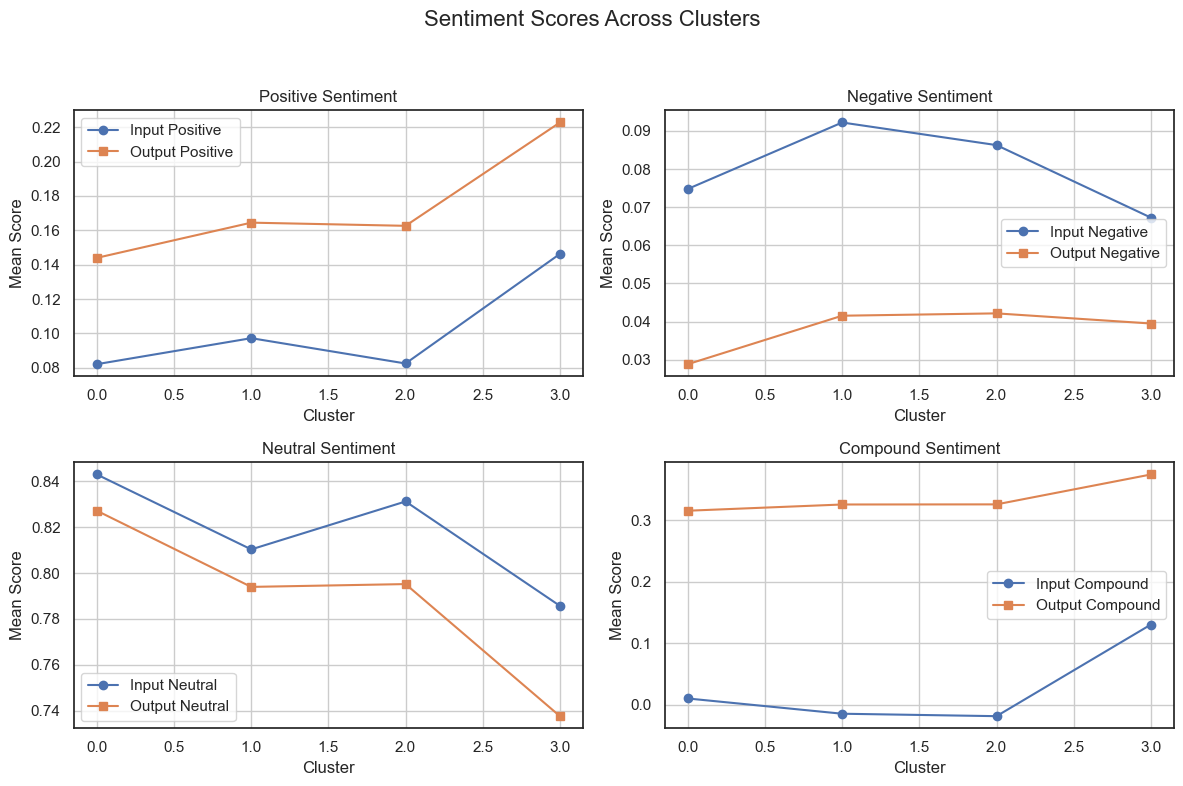

In [93]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
res = data_subset.copy(deep=True)
# Assuming 'res' is your DataFrame
# If you need to load it from a file, uncomment and adjust the path:
# res = pd.read_csv('path_to_your_file.csv')

# Ensure input and output are strings and handle missing values
res['input'] = res['input'].astype(str).fillna('')
res['output'] = res['output'].astype(str).fillna('')

# Function to compute VADER sentiment scores
def get_vader_scores(text):
    """
    Compute VADER sentiment scores for a given text.
    Args:
        text (str): Input text.
    Returns:
        dict: Dictionary with pos, neg, neu, and compound scores.
    """
    scores = analyzer.polarity_scores(text)
    return {
        'pos': scores['pos'],
        'neg': scores['neg'],
        'neu': scores['neu'],
        'compound': scores['compound']
    }

# Apply VADER sentiment analysis to input and output
print("Computing sentiment scores...")
res['input_scores'] = res['input'].apply(get_vader_scores)
res['output_scores'] = res['output'].apply(get_vader_scores)

# Expand scores into separate columns
res['input_pos'] = res['input_scores'].apply(lambda x: x['pos'])
res['input_neg'] = res['input_scores'].apply(lambda x: x['neg'])
res['input_neu'] = res['input_scores'].apply(lambda x: x['neu'])
res['input_compound'] = res['input_scores'].apply(lambda x: x['compound'])

res['output_pos'] = res['output_scores'].apply(lambda x: x['pos'])
res['output_neg'] = res['output_scores'].apply(lambda x: x['neg'])
res['output_neu'] = res['output_scores'].apply(lambda x: x['neu'])
res['output_compound'] = res['output_scores'].apply(lambda x: x['compound'])

# Drop temporary score columns
res = res.drop(['input_scores', 'output_scores'], axis=1)

print("Sentiment scores added. DataFrame shape:", res.shape)

# Aggregate mean sentiment scores by cluster
cluster_sentiment = res.groupby('kmeans_umap_cluster').agg({
    'input_pos': 'mean',
    'input_neg': 'mean',
    'input_neu': 'mean',
    'input_compound': 'mean',
    'output_pos': 'mean',
    'output_neg': 'mean',
    'output_neu': 'mean',
    'output_compound': 'mean'
}).reset_index()

print("\nMean Sentiment Scores by Cluster:")
print(cluster_sentiment.to_string(index=False))

# Create line plots for each sentiment metric
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Sentiment Scores Across Clusters', fontsize=16)

# Positive Scores
axes[0, 0].plot(cluster_sentiment['kmeans_umap_cluster'], cluster_sentiment['input_pos'], 
                label='Input Positive', marker='o')
axes[0, 0].plot(cluster_sentiment['kmeans_umap_cluster'], cluster_sentiment['output_pos'], 
                label='Output Positive', marker='s')
axes[0, 0].set_title('Positive Sentiment')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Mean Score')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Negative Scores
axes[0, 1].plot(cluster_sentiment['kmeans_umap_cluster'], cluster_sentiment['input_neg'], 
                label='Input Negative', marker='o')
axes[0, 1].plot(cluster_sentiment['kmeans_umap_cluster'], cluster_sentiment['output_neg'], 
                label='Output Negative', marker='s')
axes[0, 1].set_title('Negative Sentiment')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Mean Score')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Neutral Scores
axes[1, 0].plot(cluster_sentiment['kmeans_umap_cluster'], cluster_sentiment['input_neu'], 
                label='Input Neutral', marker='o')
axes[1, 0].plot(cluster_sentiment['kmeans_umap_cluster'], cluster_sentiment['output_neu'], 
                label='Output Neutral', marker='s')
axes[1, 0].set_title('Neutral Sentiment')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Mean Score')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Compound Scores
axes[1, 1].plot(cluster_sentiment['kmeans_umap_cluster'], cluster_sentiment['input_compound'], 
                label='Input Compound', marker='o')
axes[1, 1].plot(cluster_sentiment['kmeans_umap_cluster'], cluster_sentiment['output_compound'], 
                label='Output Compound', marker='s')
axes[1, 1].set_title('Compound Sentiment')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Mean Score')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()